In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

backend = "pyro"
platform = "cpu" # "gpu"

if backend == "pyro":
    import torch

    tensor = torch
    if platform == "cpu":
        torch.set_default_dtype(torch.float32)
    else:
        torch.set_default_dtype(torch.cuda)
    
    torch.manual_seed(111)

else:
    import jax.numpy as jnp
    import jax.random as jr
    from numpyro import set_platform
    set_platform(platform)
    
    key = jr.PRNGKey(111)
    tensor = jnp
    

A brief tutorial for simulating behaviour in a multi armed bandit task and using simulated response to invert the model and infer model parameters for individual agents/subjects

In [3]:
import numpy as np
from local import MABTask, UCBAgent
from pybefit.agents import transform

if backend == "pyro":
    from pybefit.inference import PyroGuide as Guide
    from pybefit.inference import PyroModel as Model
    from pyro.infer import Predictive
    from pybefit.inference.pyro.likelihoods import befit_likelihood as likelihood
    from pybefit.inference.methods import (
        default_dict_pyro_svi,
        format_posterior_samples,
        get_log_evidence_per_subject,
    )

    default_dict_svi = default_dict_pyro_svi

else:
    import jax.random as jr
    from pybefit.inference import NumpyroGuide as Guide
    from pybefit.inference import NumpyroModel as Model
    from numpyro.infer import Predictive
    from pybefit.inference.numpyro.likelihoods import befit_likelihood as likelihood
    from pybefit.inference.methods import (
        default_dict_numpyro_svi,
        format_posterior_samples,
        get_log_evidence_per_subject,
    )

    default_dict_svi = default_dict_numpyro_svi

from pybefit.inference.methods import default_dict_nuts
from pybefit.inference import Normal as Prior
from pybefit.inference import NormalPosterior as Posterior

from pybefit.inference import run_nuts, run_svi

We start by first generating a time sequence of possible choice outcomes for the task and pack this inside the "MABTask" class.

In [4]:
blocks = 20
trials = 10
num_arms = 3
num_agents = 100

# create task environment
probs = np.random.dirichlet(np.ones(num_arms), size=(num_agents,))
outcomes = tensor.ones(1) * np.random.binomial(
    1, probs, size=(blocks, trials, num_agents, num_arms)
).astype(np.float32)

print(outcomes.dtype, outcomes.shape)

mab_task = (
    MABTask(outcomes, backend="torch")
    if backend == "pyro"
    else MABTask(outcomes, backend="jax")
)

# create agent to recover number of parameters
if backend == "pyro":
    ucb_agent = UCBAgent(
        runs=num_agents,
        blocks=blocks,
        trials=trials,
        num_arms=num_arms,
        backend="torch",
    )
else:
    ucb_agent = UCBAgent(
        runs=num_agents, blocks=blocks, trials=trials, num_arms=num_arms, backend="jax"
    )

num_params = ucb_agent.num_params

# set task and agent option dictionaries
opts_task = {
    "task": mab_task,
    "blocks": blocks,
    "trials": trials,
    "num_agents": num_agents,
    "seed": 123
}

# set kwargs for transform which are passed to the agent constractor
if backend == "pyro":
    opts_transform = {
        "blocks": blocks,
        "trials": trials,
        "num_arms": num_arms,
        "backend": "torch",
    }
else:
    opts_transform = {
        "blocks": blocks,
        "trials": trials,
        "num_arms": num_arms,
        "backend": "jax",
    }


# set options for prior, transform and likelihood
opts_model = {"prior": {}, "transform": opts_transform, "likelihood": opts_task}

# define a transform for mapping unconstrained parameters 'z' to the corresponding agent class
transform_ucb = lambda z, **kwargs: transform(z, UCBAgent, **kwargs)

prior = Prior(num_params, num_agents, init_scale=0.1, backend=backend)
gen_model = Model(prior, transform_ucb, likelihood, opts=opts_model)
posterior = Guide(Posterior(num_params, num_agents, backend=backend))

torch.float32 torch.Size([20, 10, 100, 3])


Lets generate a sample from the generative model. This will sample from prior distribution some parameter values for each agent, and generate agent responses over the course of experiment, given the task environment.

In [5]:
pred = Predictive(gen_model, num_samples=1)
if backend == "pyro":
    prior_predictive_sample = pred()
else:
    key, _key = jr.split(key)
    prior_predictive_sample = pred(_key)

measurments = {
    "offers": None,
    "outcomes": prior_predictive_sample["outcomes"][0],
    "mask": None,
    "responses": prior_predictive_sample["responses"][0],
}

ucb_agent.set_parameters(prior_predictive_sample["z"][0])
true_vals = (ucb_agent.lr, ucb_agent.c, ucb_agent.beta)

Lets plot behavioural responses

tensor(0.8771) tensor(0.6064) tensor(8.3578)


Text(0.5, 0, 'trial')

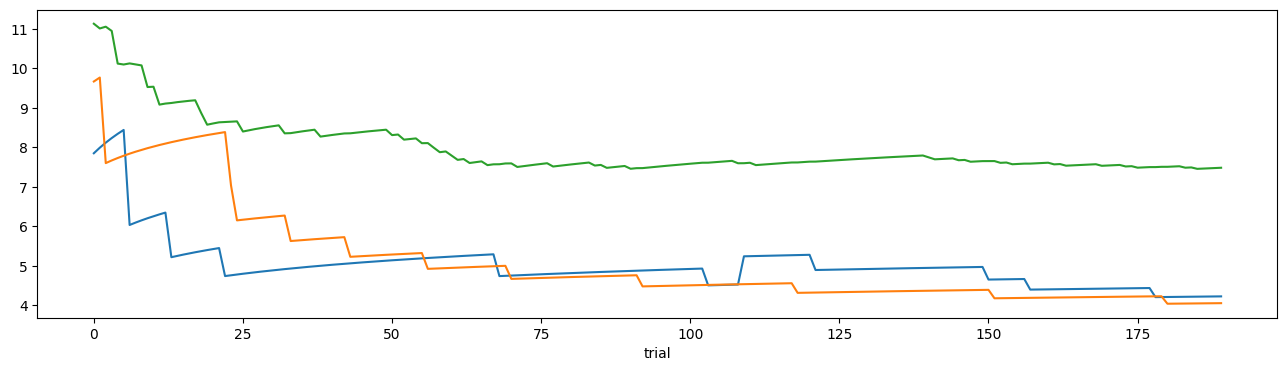

In [6]:
plt.figure(figsize=(16, 4))
s = 0
print(ucb_agent.lr[s], ucb_agent.c[s], ucb_agent.beta[s])
logits = prior_predictive_sample["logits"][0][1:, :, s, :].reshape(-1, num_arms)
plt.plot(logits)
plt.xlabel("trial")

Text(0.5, 0, 'block')

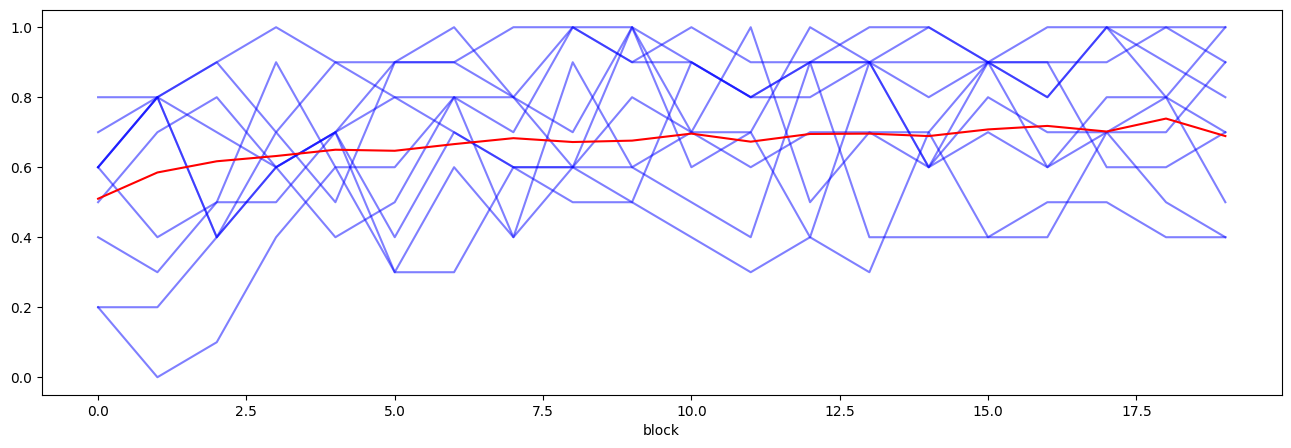

In [7]:
plt.figure(figsize=(16, 5))
perc_correct = (
    np.array(prior_predictive_sample["responses"][0]) == probs.argmax(-1)
).mean(1)
plt.plot(perc_correct[:, :10], "b", alpha=0.5)
plt.plot(perc_correct.mean(-1), "r")
plt.xlabel("block")

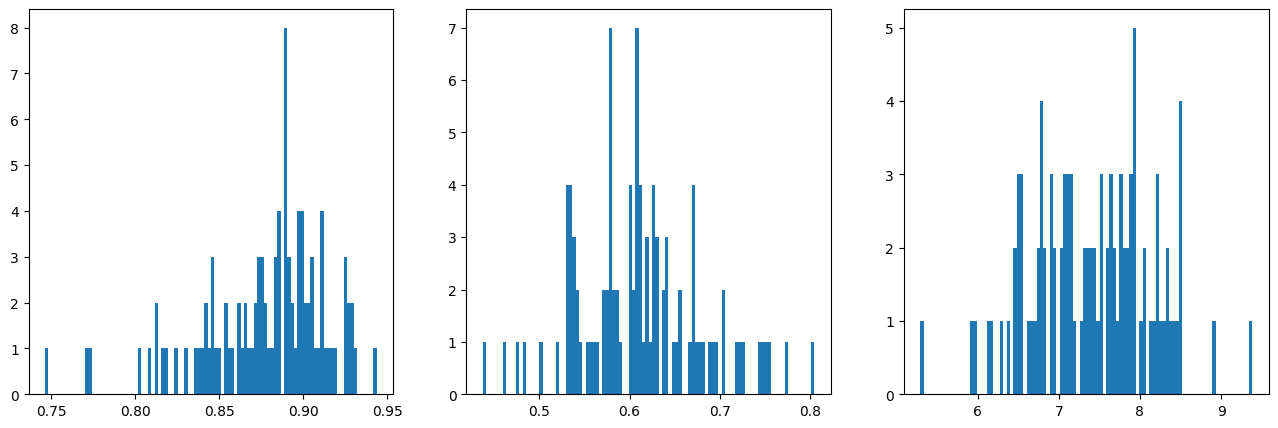

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    axes[i].hist(true_vals[i], bins=100)

In [9]:
num_samples = 1000

# perform inference using stochastic variational inference
opts_svi = default_dict_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 2_000})

samples, svi, results = run_svi(gen_model, posterior, measurments, opts=opts_svi)

  0%|          | 0/2000 [00:00<?, ?it/s]

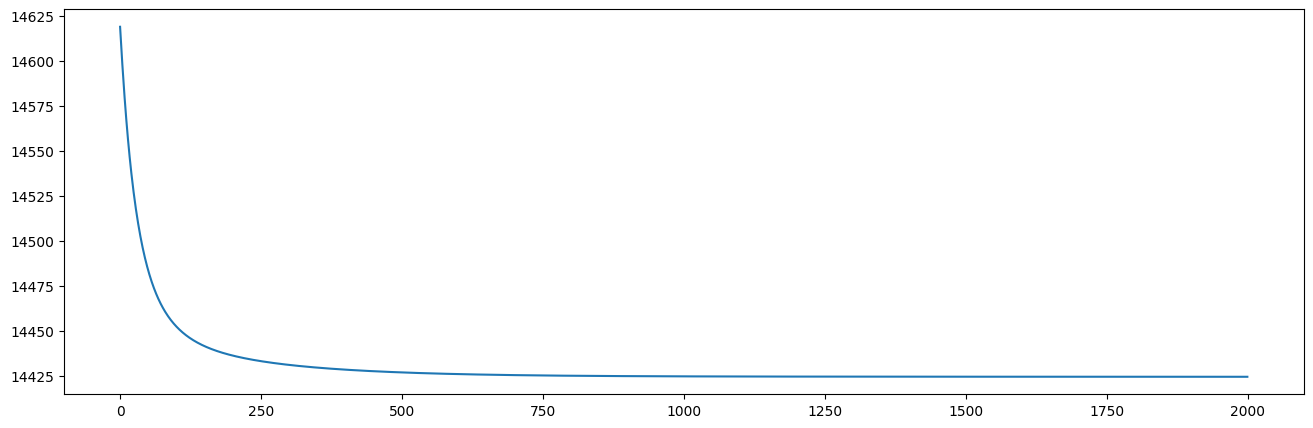

In [10]:
plt.figure(figsize=(16, 5))
plt.plot(results["loss"]) if backend == "pyro" else plt.plot(results.losses)

In [11]:
agents_ucb = transform_ucb(samples["z"], **opts_transform)
svi_samples = (agents_ucb.lr, agents_ucb.c, agents_ucb.beta)

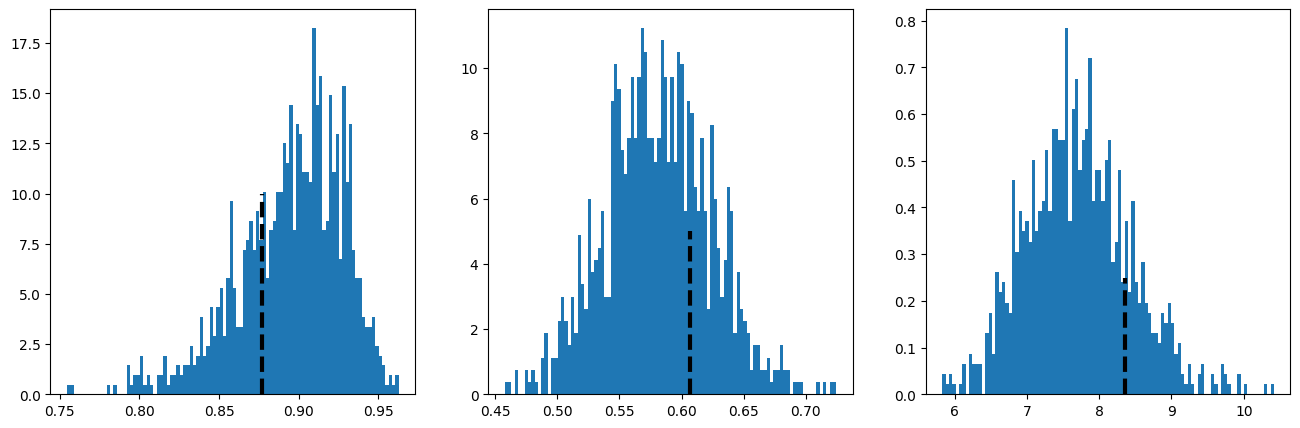

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

subject = 0
limit = [10, 5, 0.25]
for i in range(3):
    axes[i].hist(svi_samples[i][..., subject], bins=100, density=True)
    axes[i].vlines(true_vals[i][subject], 0, limit[i], "k", linestyle="--", lw=3)

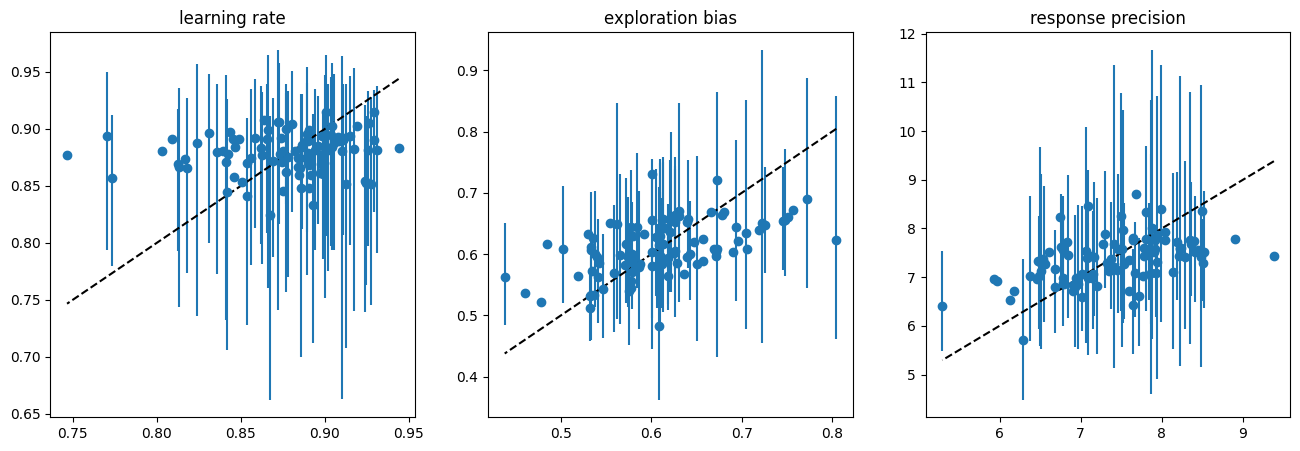

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    perc = np.percentile(svi_samples[i], [50, 5, 95], axis=0)
    yerr = np.abs(perc[1:] - perc[0])
    axes[i].errorbar(
        true_vals[i],
        perc[0],
        yerr=yerr,
        marker="o",
        errorevery=2,
        linestyle="",
    )
    v_range = (true_vals[i].max(), true_vals[i].min())
    axes[i].plot(v_range, v_range, "k--")

axes[0].set_title("learning rate")
axes[1].set_title("exploration bias")
axes[2].set_title("response precision");

In [14]:
# assert False
num_samples = 1000
num_warmup = 1000

# perform inference using stochastic variational inference
opts_nuts = default_dict_nuts
opts_nuts.update({"num_samples": num_samples, "num_warmup": num_warmup})

samples_nuts, mcmc = run_nuts(gen_model, measurments, opts=opts_nuts)

Sample: 100%|██████████| 2000/2000 [51:10,  1.54s/it, step size=2.02e-01, acc. prob=0.705]


In [15]:
agents_ucb = transform_ucb(samples_nuts["z"], **opts_transform)
nuts_samples = (agents_ucb.lr, agents_ucb.c, agents_ucb.beta)

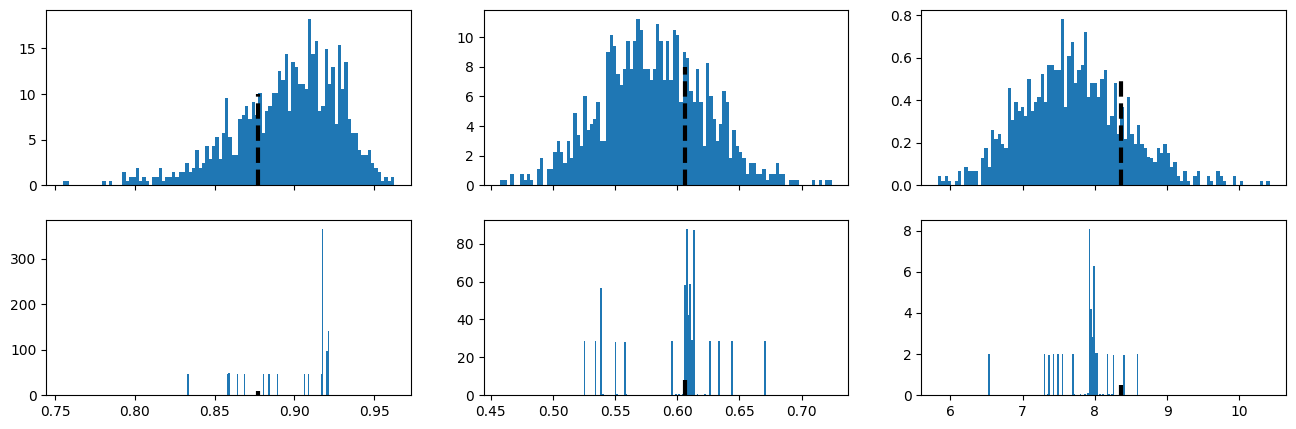

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 5), sharex="col")

subject = 0
limit = [10, 8, 0.5]
for i in range(3):
    axes[0, i].hist(svi_samples[i][..., subject], bins=100, density=True)
    axes[0, i].vlines(true_vals[i][subject], 0, limit[i], "k", linestyle="--", lw=3)

    axes[1, i].hist(nuts_samples[i][..., subject], bins=100, density=True)
    axes[1, i].vlines(true_vals[i][subject], 0, limit[i], "k", linestyle="--", lw=3)

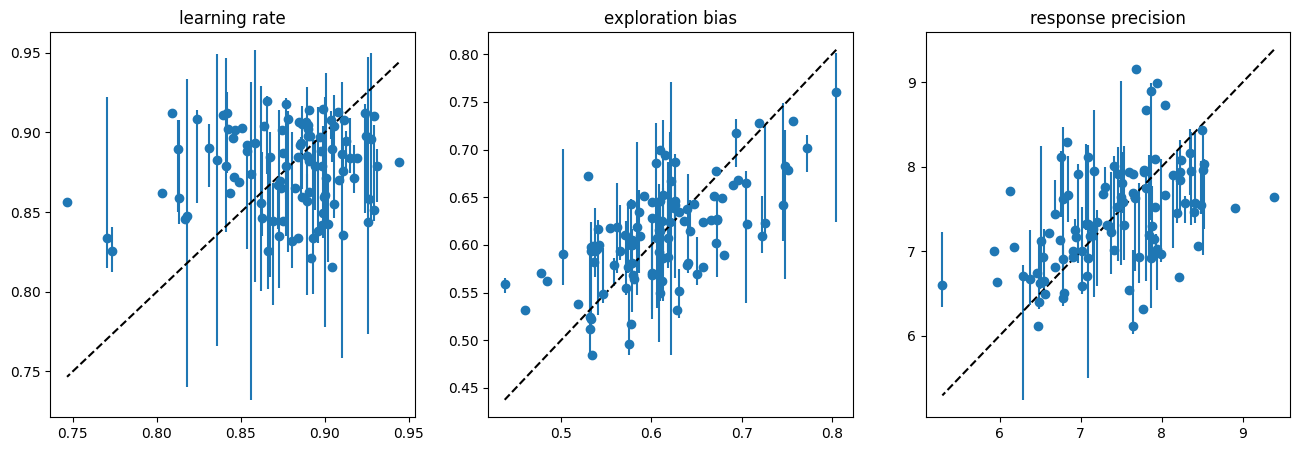

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    perc = np.percentile(nuts_samples[i], [50, 5, 95], axis=0)
    yerr = np.abs(perc[1:] - perc[0])
    axes[i].errorbar(
        true_vals[i],
        perc[0],
        yerr=yerr,
        marker="o",
        errorevery=2,
        linestyle="",
    )
    v_range = (true_vals[i].max(), true_vals[i].min())
    axes[i].plot(v_range, v_range, "k--")

axes[0].set_title("learning rate")
axes[1].set_title("exploration bias")
axes[2].set_title("response precision");